# 1. 말뭉치 전처리 (Corpus Preprocessing)

이 노트북에서는 자연어 처리의 기본이 되는 말뭉치(corpus) 전처리 과정을 다룹니다. n-gram 모델과 GloVe 임베딩을 구현하기 위한 기초 작업입니다.

## 학습 목표
- 텍스트 데이터를 불러오고 전처리하는 방법 익히기
- 토큰화(tokenization)와 정제(cleaning) 과정 이해하기
- 전처리된 데이터를 후속 분석에 적합한 형태로 저장하기

In [1]:
!pip install matplotlib

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from collections import Counter, defaultdict

# 시각화 설정
plt.style.use('ggplot')
%matplotlib inline

## 1.1 샘플 말뭉치 불러오기

먼저 샘플 말뭉치 파일(corpus.txt)을 불러옵니다. 파일이 없는 경우 간단한 샘플 텍스트를 생성합니다.

In [6]:
# 샘플 말뭉치 파일 불러오기 (없으면 샘플 생성)
try:
    with open('corpus.txt', 'r', encoding='utf-8') as f:
        corpus = f.read()
except FileNotFoundError:
    # 샘플 말뭉치 생성
    corpus = """
    자연어 처리는 컴퓨터가 인간의 언어를 이해하고 처리하는 기술입니다.
    컴퓨터는 자연어 처리를 통해 텍스트를 분석하고 의미를 추출합니다.
    인공지능과 기계학습은 자연어 처리의 핵심 기술입니다.
    딥러닝 모델은 자연어 처리 성능을 크게 향상시켰습니다.
    워드 임베딩은 단어를 벡터 공간에 표현하는 방법입니다.
    GloVe와 Word2Vec은 대표적인 워드 임베딩 알고리즘입니다.
    언어 모델은 다음 단어를 예측하는 모델입니다.
    n-gram은 연속된 n개의 단어 시퀀스를 의미합니다.
    자연어 처리는 기계 번역, 감성 분석, 정보 추출 등에 활용됩니다.
    텍스트 전처리는 자연어 처리의 첫 단계입니다.
    """
    
    # 샘플 말뭉치 저장
    with open('corpus.txt', 'w', encoding='utf-8') as f:
        f.write(corpus)

print(f"말뭉치 크기: {len(corpus)} 문자")
print("\n샘플 텍스트:")
print(corpus[:300] + "...")

말뭉치 크기: 371 문자

샘플 텍스트:

    자연어 처리는 컴퓨터가 인간의 언어를 이해하고 처리하는 기술입니다.
    컴퓨터는 자연어 처리를 통해 텍스트를 분석하고 의미를 추출합니다.
    인공지능과 기계학습은 자연어 처리의 핵심 기술입니다.
    딥러닝 모델은 자연어 처리 성능을 크게 향상시켰습니다.
    워드 임베딩은 단어를 벡터 공간에 표현하는 방법입니다.
    GloVe와 Word2Vec은 대표적인 워드 임베딩 알고리즘입니다.
    언어 모델은 다음 단어를 예측하는 모델입니다.
    n-gram은 연속된 n개의 단어 시퀀스를 의미합니다.
    자...


## 1.2 텍스트 정제 및 토큰화

텍스트 전처리는 다음 단계로 진행합니다:
1. 소문자 변환 (영어 텍스트의 경우)
2. 문장 분리
3. 특수문자 및 불필요한 기호 제거
4. 토큰화 (단어 단위로 분리)

In [7]:
def preprocess_text(text):
    # 줄바꿈 및 여러 공백 처리
    text = re.sub(r'\s+', ' ', text)
    
    # 문장 분리 (마침표, 물음표, 느낌표 기준)
    sentences = re.split(r'[.!?]\s', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    
    # 각 문장에서 특수문자 제거 및 토큰화
    tokenized_sentences = []
    for sentence in sentences:
        # 특수문자 제거 (한글, 영문, 숫자, 공백만 유지)
        clean_sentence = re.sub(r'[^\w\s가-힣]', '', sentence)
        # 토큰화 (공백 기준)
        tokens = clean_sentence.split()
        tokenized_sentences.append(tokens)
    
    return tokenized_sentences

# 전처리 적용
tokenized_corpus = preprocess_text(corpus)

# 결과 확인
print(f"전처리된 문장 수: {len(tokenized_corpus)}")
for i, sentence in enumerate(tokenized_corpus[:3]):
    print(f"문장 {i+1}: {sentence}")

전처리된 문장 수: 10
문장 1: ['자연어', '처리는', '컴퓨터가', '인간의', '언어를', '이해하고', '처리하는', '기술입니다']
문장 2: ['컴퓨터는', '자연어', '처리를', '통해', '텍스트를', '분석하고', '의미를', '추출합니다']
문장 3: ['인공지능과', '기계학습은', '자연어', '처리의', '핵심', '기술입니다']


## 1.3 어휘 사전(Vocabulary) 구축

모든 고유 단어를 수집하고, 각 단어에 고유 ID를 할당합니다. 이는 n-gram 모델과 GloVe 임베딩에서 중요한 기초 작업입니다.

In [8]:
def build_vocabulary(tokenized_sentences):
    # 모든 단어 수집
    all_words = [word for sentence in tokenized_sentences for word in sentence]
    
    # 단어 빈도 계산
    word_counts = Counter(all_words)
    
    # 빈도순으로 정렬 (가장 빈번한 것부터)
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
    # 단어에 ID 할당 (빈도순)
    word_to_id = {word: i for i, (word, _) in enumerate(sorted_words)}
    id_to_word = {i: word for word, i in word_to_id.items()}
    
    return word_to_id, id_to_word, word_counts

word_to_id, id_to_word, word_counts = build_vocabulary(tokenized_corpus)

# 어휘 사전 정보 출력
vocab_size = len(word_to_id)
print(f"어휘 사전 크기: {vocab_size} 단어")
print("\n가장 빈번한 단어 10개:")
for word, count in list(word_counts.most_common(10)):
    print(f"{word}: {count}회")

어휘 사전 크기: 59 단어

가장 빈번한 단어 10개:
자연어: 6회
처리는: 2회
기술입니다: 2회
처리의: 2회
모델은: 2회
워드: 2회
단어를: 2회
컴퓨터가: 1회
인간의: 1회
언어를: 1회


## 1.4 단어 빈도 시각화

In [11]:
!pip install koreanize_matplotlib
import koreanize_matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 34.2 MB/s eta 0:00:00m eta 0:00:010:01:01


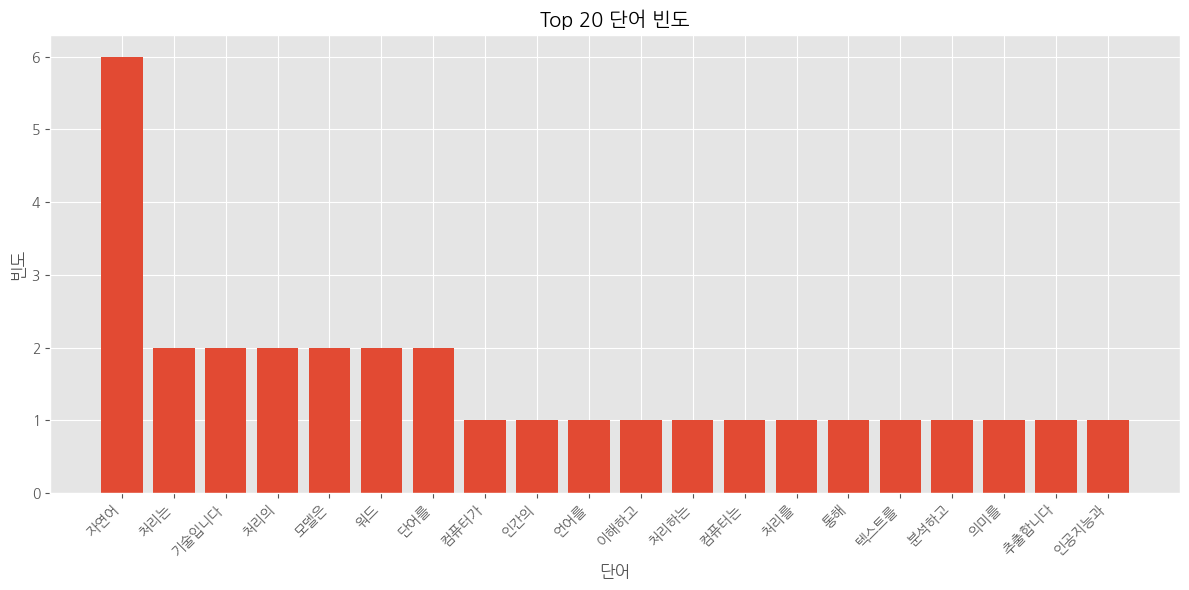

In [12]:
def plot_word_frequency(word_counts, top_n=20):
    most_common = word_counts.most_common(top_n)
    words, counts = zip(*most_common)
    
    plt.figure(figsize=(12, 6))
    plt.bar(words, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top {top_n} 단어 빈도')
    plt.xlabel('단어')
    plt.ylabel('빈도')
    plt.tight_layout()
    plt.show()

plot_word_frequency(word_counts)

## 1.5 전처리 데이터 저장

후속 분석을 위해 전처리된 데이터를 저장합니다.

In [13]:
import pickle

# 전처리 결과 저장
preprocessing_results = {
    'tokenized_corpus': tokenized_corpus,
    'word_to_id': word_to_id,
    'id_to_word': id_to_word,
    'word_counts': word_counts
}

with open('preprocessing_results.pkl', 'wb') as f:
    pickle.dump(preprocessing_results, f)

print("전처리 결과가 'preprocessing_results.pkl' 파일에 저장되었습니다.")

전처리 결과가 'preprocessing_results.pkl' 파일에 저장되었습니다.


## 1.6 요약 및 다음 단계

이 노트북에서는 텍스트 데이터를 불러와 전처리하고, 어휘 사전을 구축했습니다. 주요 단계는 다음과 같습니다:

1. 말뭉치 불러오기
2. 텍스트 정제 및 토큰화
3. 어휘 사전 구축
4. 단어 빈도 시각화
5. 전처리 데이터 저장

다음 노트북에서는 이 전처리 결과를 활용하여 n-gram 모델을 구현하게 됩니다.

## 연습 문제

1. 현재 전처리 과정에 불용어(stopwords) 제거 기능을 추가해보세요.
2. 한국어 형태소 분석기(예: KoNLPy)를 사용하여 토큰화를 개선해보세요.
3. 단어 빈도가 지프의 법칙(Zipf's law)을 따르는지 로그-로그 스케일로 시각화해보세요.